In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

In [2]:
USAhousing = pd.read_csv('USA_Housing.csv')

In [3]:
X = USAhousing[['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
               'Avg. Area Number of Bedrooms', 'Area Population']]
y = USAhousing['Price']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [7]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Avg. Area Income,21.528276
Avg. Area House Age,164883.282027
Avg. Area Number of Rooms,122368.678027
Avg. Area Number of Bedrooms,2233.801864
Area Population,15.150420


In [8]:
predictions = lm.predict(X_test)

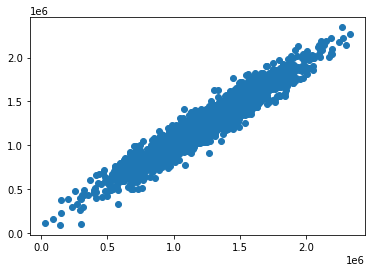

In [9]:
plt.scatter(y_test,predictions)

In [10]:
# calculate these metrics by hand!
from sklearn import metrics
from sklearn.metrics import r2_score

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions)) #manually with sum(residuals.apply(lambda x: x**2))/len(residuals)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2:', r2_score(y_test, predictions))

r, p = stats.pearsonr(y_test, predictions)
print('R2 as square correlation:', r**2)

MAE: 82288.22251914954
MSE: 10460958907.2095
RMSE: 102278.82922291152
R2: 0.91768240096492
R2 as square correlation: 0.9178201607417024


In [11]:
residuals = y_test -predictions

In [12]:
residuals.var()

10448952333.173538

In [13]:
model_variances = []

In [14]:
model_variances.append(1/residuals.var())

In [15]:
model_variances

[9.570337466514997e-11]

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 20, 50, 75, 100]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [18]:
# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   17.7s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [10, 20, 50, 75, 100]},
             verbose=2)

In [30]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,
                      min_samples_split=8)

In [20]:
predictions_rfr = best_grid.predict(X_test)

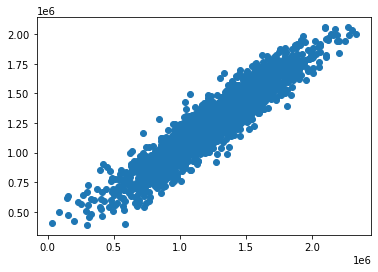

In [21]:
plt.scatter(y_test,predictions_rfr)

In [22]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions_rfr))
print('MSE:', metrics.mean_squared_error(y_test, predictions_rfr)) #manually with sum(residuals.apply(lambda x: x**2))/len(residuals)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_rfr)))
print('R2:', r2_score(y_test, predictions_rfr))

r, p = stats.pearsonr(y_test, predictions_rfr)
print('R2 as square correlation:', r**2)

MAE: 100430.13019748186
MSE: 16323263595.182035
RMSE: 127762.52813396437
R2: 0.8715517497496272
R2 as square correlation: 0.8783553236322498


In [23]:
rfr_residuals = y_test - predictions_rfr

In [27]:
model_variances.append(1/rfr_residuals.var())

In [28]:
model_variances

[9.570337466514997e-11, 6.127252051335122e-11]

In [41]:
from sklearn.ensemble import VotingRegressor

In [46]:
rf2 = RandomForestRegressor(**grid_search.best_params_)
lr2 = LinearRegression()


In [47]:
w1 = (model_variances[0])/sum(model_variances)
w2 = (model_variances[1])/sum(model_variances)

weights = [w1,w2]
weights

[0.6096692397028428, 0.3903307602971572]

In [48]:

er = VotingRegressor([('lr', lr2), ('rf', rf2)], weights=weights)

In [49]:
er.fit(X_train,y_train)


VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('rf',
                             RandomForestRegressor(max_depth=90, max_features=3,
                                                   min_samples_leaf=3,
                                                   min_samples_split=8))],
                weights=[0.6096692397028428, 0.3903307602971572])

In [50]:
er_predictions = er.predict(X_test)

In [51]:
print('MAE:', metrics.mean_absolute_error(y_test, er_predictions))
print('MSE:', metrics.mean_squared_error(y_test, er_predictions)) #manually with sum(residuals.apply(lambda x: x**2))/len(residuals)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, er_predictions)))
print('R2:', r2_score(y_test, er_predictions))

r, p = stats.pearsonr(y_test, er_predictions)
print('R2 as square correlation:', r**2)

MAE: 85759.01094373682
MSE: 11359964703.396378
RMSE: 106583.13517342403
R2: 0.9106080974218937
R2 as square correlation: 0.9124474946511929
